# XOR Neural Network - Eager Execution
* XOR 문제를 Neural Network을 활용해 풀어보도록 하겠습니다.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


## Train Data
* XOR 문제를 해결하기 위한 트레이닝 데이터
* XOR은 데이터의 값이 같으면 0, 다르면 1을 나타낸다.

x1 | x2 | Y
---- | ---- | ----
0 | 0 | 0
0 | 1 | 1 
1 | 0 | 1
1 | 1 | 0

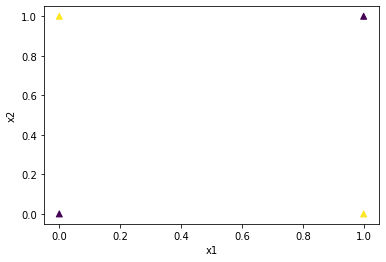

In [25]:
data = np.array([
    # X1,  X2,  y
    [ 0.,  0.,  0. ],
    [ 0.,  1.,  1. ],
    [ 1.,  0.,  1. ],
    [ 1.,  1.,  0. ]
], dtype=np.float32)

# slice data
# train data
x_train = data[:, :-1] # 4행 2열
y_train = data[:, [-1]] # 4행 1열(마지막 열)

# test data
x_test = [[2.,2.]]
y_test = [[0.]]

x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 2) for y in y_train]
plt.scatter(x1,x2, c=colors , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

##  Tensorflow Eager
### 위 Data를 기준으로 XOR처리를 위한 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()
print(dataset)

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>


### 위 Data를 기준으로 가설의 검증을 통해 XOR처리를 위한 모델을 만들도록 하겠습니다
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

![XOR NN](./pictures/xor_nn_01.PNG)

In [12]:
tf.random.set_seed(0)  # for reproducibility

# 0의 값으로 변수 설정
#W = tf.Variable(tf.zeros([2,1]), name='weight')
#b = tf.Variable(tf.zeros([1]), name='bias') 
# 임의의 값으로 변수 설정
W1 = tf.Variable(tf.random.normal((2, 2))) # 2행 2열
b1 = tf.Variable(tf.random.normal((2,)))

W2 = tf.Variable(tf.random.normal((2, 1))) # 2행 1열
b2 = tf.Variable(tf.random.normal((1,)))

## Step 1: Hypothesis using matrix(가설 or 모델)
### Sigmoid 함수를 활성화 함수로 설정
* Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [13]:
# 가설
def neural_net(features):
    layer = tf.sigmoid(tf.matmul(features, W1) + b1)
    hypothesis  = tf.sigmoid(tf.matmul(layer, W2) + b2)
    return hypothesis

## Step 2: Cost Function (손실 함수)
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 위 두수식을 합치면 아래과 같습니다
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [14]:
def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

## Step 3: Optimizer (Minimize Cost Function)
### Gradient descent
$$ W := W-\alpha \frac { \partial  }{ \partial W } cost(W) $$

In [15]:
# 경사 하강법
# tf.GradientTape() 사용
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features), labels)
    return tape.gradient(loss_value, [W1, W2, b1, b2])

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
* Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.
* 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [20]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.int32))
    return accuracy

## 훈련

In [16]:
# 훈련 반복 횟수 설정
epoch = 50000
for step in range(epoch + 1):
    for features, labels  in iter(dataset):
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, b1, b2]))
        if step % 5000 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(neural_net(features),labels)))

Iter: 0, Loss: 0.6909
Iter: 5000, Loss: 0.6448
Iter: 10000, Loss: 0.5668
Iter: 15000, Loss: 0.3992
Iter: 20000, Loss: 0.2010
Iter: 25000, Loss: 0.1143
Iter: 30000, Loss: 0.0767
Iter: 35000, Loss: 0.0569
Iter: 40000, Loss: 0.0449
Iter: 45000, Loss: 0.0369
Iter: 50000, Loss: 0.0313


## Predict (예측)

In [17]:
y_train # labels, 실제값

array([[0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [18]:
neural_net(x_train).numpy() # prediction, 예측값

array([[0.03049443],
       [0.9626765 ],
       [0.9704943 ],
       [0.0257471 ]], dtype=float32)

In [26]:
# 테스트 데이터에 대한 예측
test_acc = accuracy_fn(neural_net(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Testset Accuracy: 1.0000
